#Dependencies

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import string
from tqdm import tqdm
from multiprocessing import Pool
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score, roc_curve, precision_score, recall_score

import warnings
warnings.filterwarnings('ignore')

# Dataset
https://www.kaggle.com/datasets/yasserh/twitter-tweets-sentiment-dataset

In [2]:
# Dataseti yüklüyoruz
df = pd.read_csv('dataset/Tweets.csv')
# İlk 5 satır kontrol
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


# EDA İşlemlerinin Yapılması
Temel özellikleri özetleyip verileri görselleştir

In [3]:
# İşime yaramayacağı için text ve textid sütunlarını droplayacağım
df.drop(['selected_text', 'textID'], axis=1, inplace=True)
target = 'sentiment'
# Index tutarlılığı için reset_index fonksiyonu kullandıktan sonra df'in kopyasını saklıyorum
df.reset_index(drop=True, inplace=True)
original_df = df.copy(deep=True)
df.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [4]:
# Verisetinin boyutu
print('Dimentions of dataset:', df.shape)
# Veri tipleri kontrol
df.info()

Dimentions of dataset: (27481, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       27480 non-null  object
 1   sentiment  27481 non-null  object
dtypes: object(2)
memory usage: 429.5+ KB


In [5]:
df.describe()

,text,sentiment
count,27480,27481
unique,27480,3
top,"I`d have responded, if I were going",neutral
freq,1,11118


- Verisetimiz 27481 satır ve 2 sütündan oluşuyor
- Text sütununda Null olmayan 27480 , sentiment sütunundan ise 27480 entry var
- İki sütunun da veri tipi object , metin verisi(karışık) içeriyorlar
- positive , negative ve neutral olmak üzere 3 unique sentiment var  

In [6]:
df.isnull().sum()

,0
text,1
sentiment,0


In [7]:
# Text sütununda bulunan null satırı atacağım
df.dropna(inplace=True)
original_df = df.copy()

In [8]:
# Birbirinin kopyası olan satır var mı kontrol ediyorum
df.duplicated().sum()


0

In [9]:
# Her satırda kaç kelime var kontrol ediyorum ( stringe çevirip boşluklara göre ayırıp her kelimeyi sayıyorum )
df['word_count'] = df['text'].apply(lambda x: len(str(x).split(" ")))
df[['text','word_count']].head()

,text,word_count
0,"I`d have responded, if I were going",8
1,Sooo SAD I will miss you here in San Diego!!!,11
2,my boss is bullying me...,5
3,what interview! leave me alone,6
4,"Sons of ****, why couldn`t they put them on t...",15


In [10]:
# Boşluklarla birlikte kararkter sayısı
df['char_count'] = df['text'].str.len() # boşlukları da katmak için
df[['text','char_count']].head()

,text,char_count
0,"I`d have responded, if I were going",36
1,Sooo SAD I will miss you here in San Diego!!!,46
2,my boss is bullying me...,25
3,what interview! leave me alone,31
4,"Sons of ****, why couldn`t they put them on t...",75


In [11]:
# Ortalama kelime uzunluğu
def avg_word(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words)/len(words))
df['avg_word'] = df['text'].apply(lambda x: avg_word(x))
df[['text','avg_word']].head()


,text,avg_word
0,"I`d have responded, if I were going",4.142857
1,Sooo SAD I will miss you here in San Diego!!!,3.600000
2,my boss is bullying me...,4.200000
3,what interview! leave me alone,5.200000
4,"Sons of ****, why couldn`t they put them on t...",4.357143


In [12]:
# Etkisiz kelime ( stop word) sayısı
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

df['stopwords'] = df['text'].apply(lambda x: len([x for x in x.split() if x in stop]))
df[['text','stopwords']].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,stopwords
0,"I`d have responded, if I were going",3
1,Sooo SAD I will miss you here in San Diego!!!,4
2,my boss is bullying me...,2
3,what interview! leave me alone,2
4,"Sons of ****, why couldn`t they put them on t...",7


In [13]:
# Twitter verisi olduğu için özel karakter kontrol ediyorum ( hashtag )
df['hastags'] = df['text'].apply(lambda x: len([x for x in x.split() if x.startswith('@')]))
df[['text','hastags']].head()

,text,hastags
0,"I`d have responded, if I were going",0
1,Sooo SAD I will miss you here in San Diego!!!,0
2,my boss is bullying me...,0
3,what interview! leave me alone,0
4,"Sons of ****, why couldn`t they put them on t...",0


In [14]:
# Metin içinde bulunan rakamların sayısını kontrol ediyorum
df['numerics'] = df['text'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
df[['text','numerics']].head()

,text,numerics
0,"I`d have responded, if I were going",0
1,Sooo SAD I will miss you here in San Diego!!!,0
2,my boss is bullying me...,0
3,what interview! leave me alone,0
4,"Sons of ****, why couldn`t they put them on t...",0


# Wordcloud
  Kelimeleri görselleştiriyorum

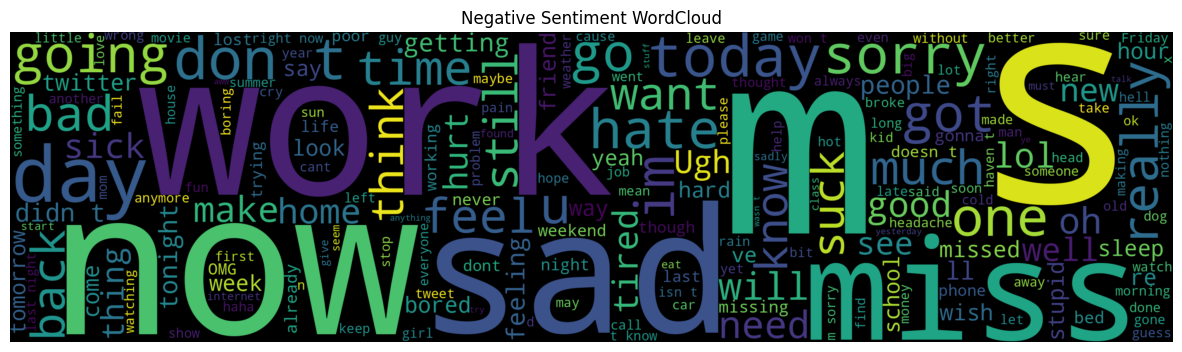

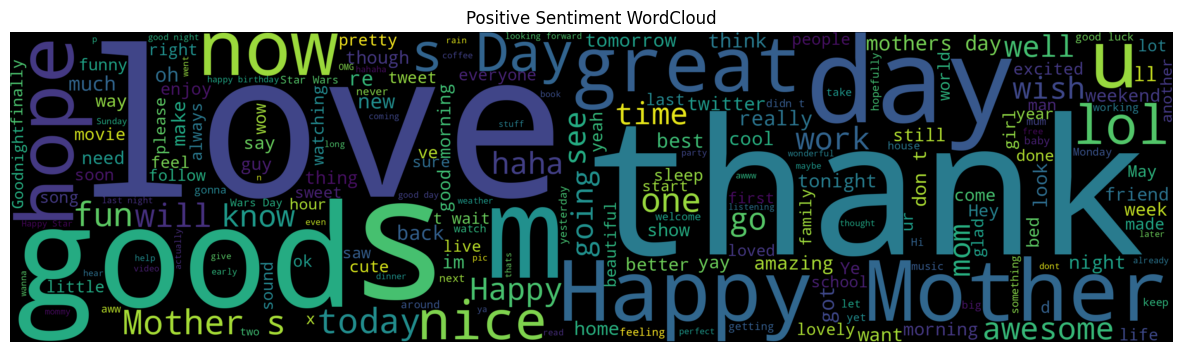

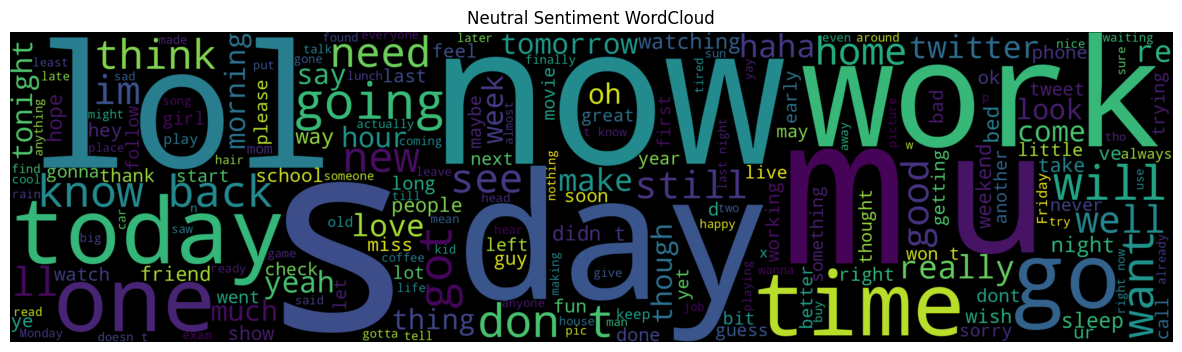

In [51]:
from wordcloud import WordCloud, STOPWORDS
# Her duygusal duruma göre df oluşturuyorum
negative_df = df[df['sentiment'] == 'negative']
positive_df = df[df['sentiment'] == 'positive']
neutral_df = df[df['sentiment'] == 'neutral']

# WordCloud oluşturmak için fonksiyon
def generate_wordcloud(data, title):
    words = ' '.join(data['text'])
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word    # linkler çıkartmak
                                and not word.startswith('@')  # mention'ları çıkartmak
                                and word != 'RT' ])  # Retweetleri çıkartmak
    wordcloud = WordCloud(stopwords=STOPWORDS,background_color='black',   # the, and, is gibi önemsiz kelimeler çıkarttık,
                          width=3000, height=800).generate(cleaned_word)  # arkaplanı siyah yaptık, boyutları belirttik
    plt.figure(figsize=(15, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()
# Wordcloud'ları görselleştirme
generate_wordcloud(negative_df, 'Negative Sentiment WordCloud')
generate_wordcloud(positive_df, 'Positive Sentiment WordCloud')
generate_wordcloud(neutral_df, 'Neutral Sentiment WordCloud')

### Yukarıda görüldüğü üzere bazı anlamsız ve işimize yaramayacak kelimeler var çünkü WordCloud kelimelerin frekansına göre oluşturuluyor, bunları temizleyeceğiz.

# Ön İşleme Aşaması

In [15]:
# Küçük harfe dönüştürme
df['text'] = df['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))

# Noktalama işaretlerini kaldırma
df['text'].str.replace('[^\w\s]', '', regex=True) # \s boşluk karakteri, \w harf rakam ve alt çizgi için kullanılır. bunların dışındakileri kaldırıyoruz

# Etkisiz kelimeleri kaldırıyoruz
from nltk.corpus import stopwords
stop = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['text'].head()

,text
0,"i`d responded, going"
1,sooo sad miss san diego!!!
2,boss bullying me...
3,interview! leave alone
4,"sons ****, couldn`t put releases already bought"


### Sık kullanılan kelimeleri kaldırıyoruz
Verisetimizde en sık kullanılan kelimeleri, karakterleri inceleyip kaldırmaya gerek olup olmadığını kontrol ediyorum


In [16]:
freq = pd.Series(' '.join(df['text']).split()).value_counts()[:30]
freq

,count
i`m,2173
day,1481
get,1415
good,1325
like,1303
it`s,1174
go,1162
-,1147
got,1069
going,1062


In [17]:
freq =["I'm", "-", "****", "&"] # Kaldırmaya karar verdiğim karakterler
df['text']= df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
df['text'].head()

,text
0,"i`d responded, going"
1,sooo sad miss san diego!!!
2,boss bullying me...
3,interview! leave alone
4,"sons ****, couldn`t put releases already bought"


In [18]:
# Nadir kullanılan kelimelerin kaldırılması
# Az kullanılan kelimelerin mevcut kelimelerle olan ilişkisi analizde gürültü (noise) yaratabilir. Bu nedenle, bu kelimeleri tespit edip ve temizliyorum
freq = pd.Series(' '.join(df['text']).split()).value_counts()[-10:]
freq

,count
neaaarr,1
wer,1
sigh.....,1
@_harrykim,1
#design,1
http://tinyurl.com/dl2upx,1
resources,1
pours.,1
cyalater!!!,1
((hugs)),1


In [19]:
#Stemming Soneklerin ("ing", "ly", "s" gibi) kaldırılmasını ifade ediyor
from nltk.stem import PorterStemmer
st = PorterStemmer()
df['text'][:5].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

,text
0,"i`d responded, go"
1,sooo sad miss san diego!!!
2,boss bulli me...
3,interview! leav alon
4,"son ****, couldn`t put releas alreadi bought"


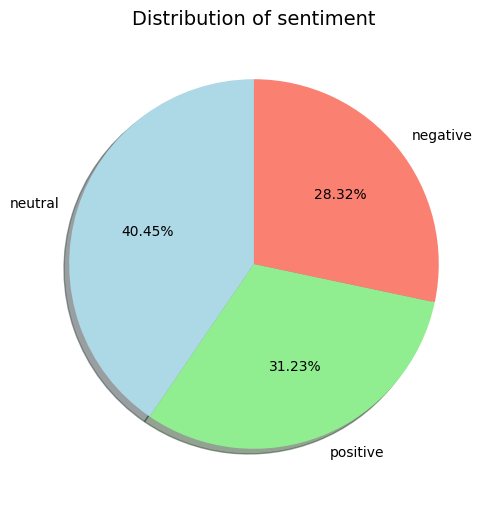

In [57]:
# frekans
value_counts = df[target].value_counts()

# Pasta grafiğini oluştur
plt.figure(figsize=(8, 6))  # Grafik boyutu
value_counts.plot.pie(
    autopct='%1.2f%%',    # Yüzde gösterimi
    startangle=90,
    colors=['lightblue', 'lightgreen', 'salmon'],
    shadow=True           # Gölgeli görünüm
)

# Başlık ekle
plt.title(f'Distribution of {target}', fontsize=14)

# Pie grafiği
plt.ylabel('')  # Y ekseni etiketi gereksiz, sol taraf sade olsun diye boş bıraktım
plt.show()

# Ön işleme sonrası WordCloud'ın görüntüsünü kontrol edelim

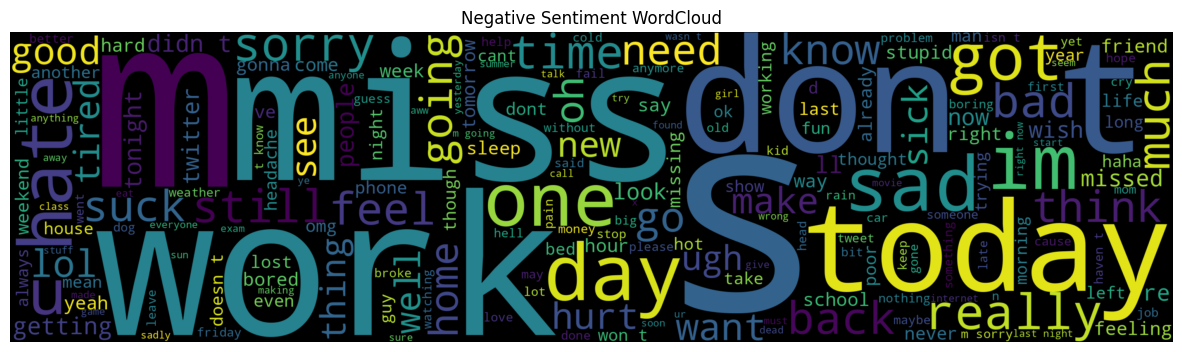

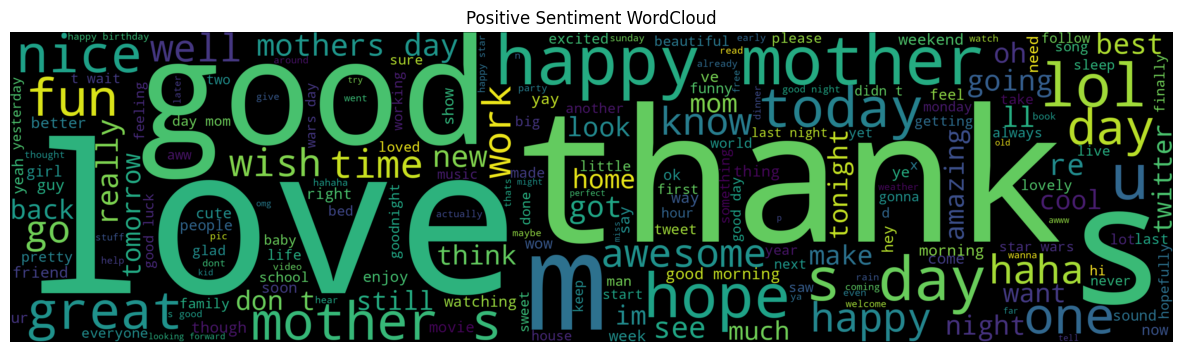

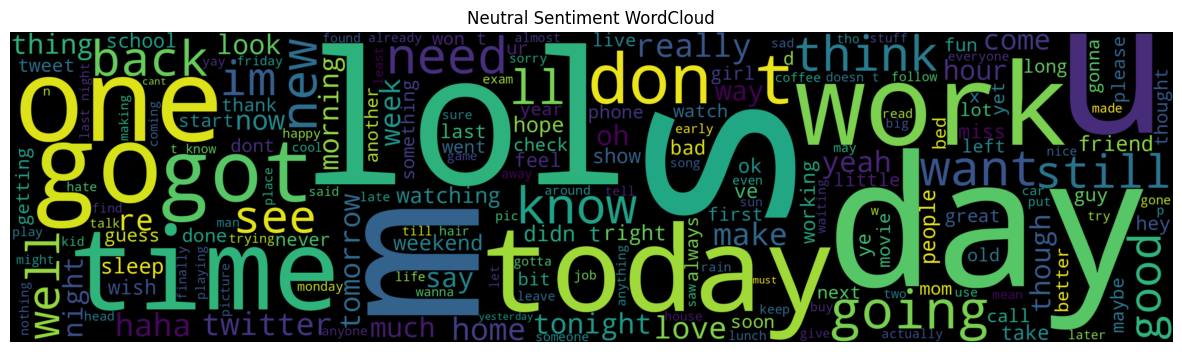

In [58]:
from wordcloud import WordCloud, STOPWORDS
negative_df = df[df['sentiment'] == 'negative']
positive_df = df[df['sentiment'] == 'positive']
neutral_df = df[df['sentiment'] == 'neutral']

# Define a function to generate and display a WordCloud
def generate_wordcloud(data, title):
    words = ' '.join(data['text'])
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT' ])
    wordcloud = WordCloud(stopwords=STOPWORDS,background_color='black',
                          width=3000, height=800).generate(cleaned_word)
    plt.figure(figsize=(15, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()
# Generate and display WordClouds for each sentiment category
generate_wordcloud(negative_df, 'Negative Sentiment WordCloud')
generate_wordcloud(positive_df, 'Positive Sentiment WordCloud')
generate_wordcloud(neutral_df, 'Neutral Sentiment WordCloud')

# Özellik çıkarımı ve temel modelleme

In [20]:
X = df['text']
y = df['sentiment']


In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer ()
X = vectorizer.fit_transform(X).toarray()
vectorizer

TfidfVectorizer()

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) # %80 %20 train test split


In [23]:
# Modellerin sonuçlarını kaydetmek için table oluşturuyorum
results_df = pd.DataFrame(np.zeros((1,5)), columns=['Accuracy', 'Precision','Recall','F1-score','AUC-ROC score'])
results_df.index=['Logistic Regression (LR)'] #'Naive Bayes Classifier (NB)', 'Random Forest Classifier (RF)', 'Support Vector Classifier (SVC)'
results_df                                    # Şimdilik performansı gözlemleyip karmaşık karar sınırları gerektirirse diğer algoritmaları da deneyeceğim.

,Accuracy,Precision,Recall,F1-score,AUC-ROC score
Logistic Regression (LR),0.0,0.0,0.0,0.0,0.0


In [ ]:
!pip install scikit-plot  ## hala hata alınıyorsa F5

In [24]:
# Fonksiyonları tanımlayıp Prediction skorlarını yuvarlıyorum
from scikitplot.metrics import plot_roc_curve as auc_roc
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score, roc_curve, precision_score, recall_score

#Classification Summary Function
def Classification_Summary(pred,pred_prob,i):
    results_df.iloc[i]['Accuracy']=round(accuracy_score(y_test, pred),3)*100
    results_df.iloc[i]['Precision']=round(precision_score(y_test, pred, average='weighted'),3)*100 #, average='weighted'
    results_df.iloc[i]['Recall']=round(recall_score(y_test, pred, average='weighted'),3)*100 #, average='weighted'
    results_df.iloc[i]['F1-score']=round(f1_score(y_test, pred, average='weighted'),3)*100 #, average='weighted'
    results_df.iloc[i]['AUC/ROC score']=round(roc_auc_score(y_test, pred_prob, multi_class='ovr'),3)*100 #, multi_class='ovr'
    print('{}{}\033[1m Evaluating {} \033[0m{}{}\n'.format('<'*3,'-'*35,results_df.index[i], '-'*35,'>'*3))
    print('Accuracy = {}%'.format(round(accuracy_score(y_test, pred),3)*100))
    print('F1 Score = {}%'.format(round(f1_score(y_test, pred, average='weighted'),3)*100)) #, average='weighted'
    print('\n \033[1mConfusiton Matrix:\033[0m\n',confusion_matrix(y_test, pred))
    print('\n\033[1mClassification Report:\033[0m\n',classification_report(y_test, pred))

    auc_roc(y_test, pred_prob, curves=['each_class'])
    plt.show()

In [25]:
# Fonksiyonu görselleştirmek
def AUC_ROC_plot(y_test, pred):
    ref = [0 for _ in range(len(y_test))]
    ref_auc = roc_auc_score(y_test, ref)
    lr_auc = roc_auc_score(y_test, pred)

    ns_fpr, ns_tpr, _ = roc_curve(y_test, ref)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, pred)

    plt.plot(ns_fpr, ns_tpr, linestyle='--')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='AUC = {}'.format(round(roc_auc_score(y_test, pred)*100,2)))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

# Logistic Regression Modeli


<<<----------------------------------- Evaluating Logistic Regression (LR) ----------------------------------->>>

Accuracy = 68.60000000000001%
F1 Score = 68.5%

 Confusiton Matrix:
 [[ 851  585   87]
 [ 257 1774  244]
 [  51  502 1145]]

Classification Report:
               precision    recall  f1-score   support

    negative       0.73      0.56      0.63      1523
     neutral       0.62      0.78      0.69      2275
    positive       0.78      0.67      0.72      1698

    accuracy                           0.69      5496
   macro avg       0.71      0.67      0.68      5496
weighted avg       0.70      0.69      0.68      5496



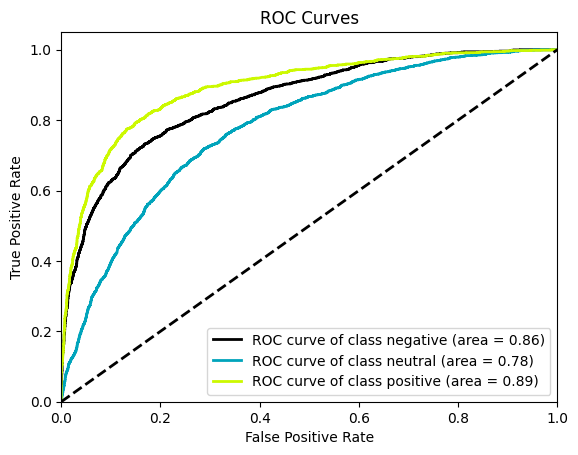

In [26]:
# Logistic Regression Sınıflandırması
from sklearn.linear_model import LogisticRegression

LR_model = LogisticRegression()
LR = LR_model.fit(X_train, y_train)

pred = LR.predict(X_test)
pred_prob = LR.predict_proba(X_test)
Classification_Summary(pred,pred_prob,0)

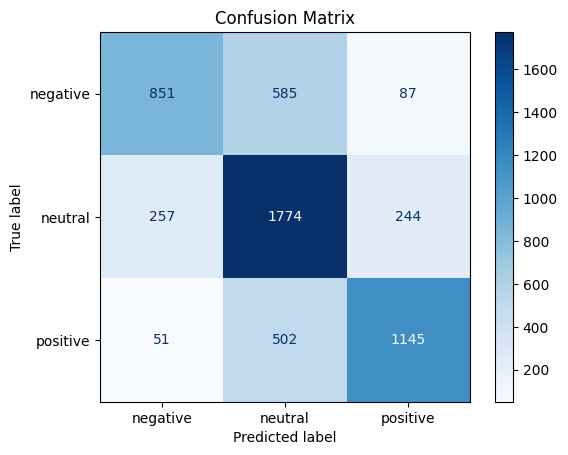

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Tahminleri al
y_pred = LR.predict(X_test)  # Modelin test veri seti üzerindeki tahminleri

# Confusion matrix hesaplama
conf_matrix = confusion_matrix(y_test, y_pred)

# Confusion matrix görselleştirme
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=LR.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()


# 3. Transformer Tabanlı Dil Modelleri
- Model olarak BERT kullanacağız.
- Eğitim ve değerlendirme süreçleri uygulanacak.

In [ ]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

# Tokenizer'ı DistilBERT için yükle
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Modeli DistilBERT için yapılandır
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)

from transformers import AdamW
from torch.utils.data import DataLoader, Dataset, random_split
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
df_Bert = df.drop(columns=['word_count', 'char_count', 'avg_word', 'stopwords', 'hastags', 'numerics'])
# String etiketleri sayısal değerlere eşleştir
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}

# Sayısal etiketleri oluştur
df_Bert['sentiment'] = df_Bert['sentiment'].map(label_map)

# Artık sentiment sütununda 0, 1 ve 2 bulunacak.
texts = df_Bert['text'].values
labels = df_Bert['sentiment'].values

# Eğitim ve test setlerini ayırma
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['text'].tolist(),
    data['label'].tolist(),
    test_size=0.2,
    random_state=42
)

# Eğitim setini küçültme (400 örnek seçmek için)
small_train_texts, _, small_train_labels, _ = train_test_split(
    train_texts, train_labels, train_size=400, random_state=42
)


In [ ]:
# 2. Tokenizer ve Dataset Oluşturma
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenize edilmiş metinleri hazırlama
train_encodings = tokenizer(small_train_texts, truncation=True, padding=True, max_length=128, return_tensors='pt')
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128, return_tensors='pt')

# PyTorch Dataset sınıfı
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_dataset = SentimentDataset(train_encodings, small_train_labels)
test_dataset = SentimentDataset(test_encodings, test_labels)

# DataLoader'lar
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [ ]:
# 3. Model ve Optimizer Ayarları
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-5)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# 4. Model Eğitimi
epochs = 20
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()
        batch = {key: val.to(device) for key, val in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")


Epoch 1/20, Loss: 0.2097
Epoch 2/20, Loss: 0.1238
Epoch 3/20, Loss: 0.0740
Epoch 4/20, Loss: 0.0268
Epoch 5/20, Loss: 0.0141
Epoch 6/20, Loss: 0.0099
Epoch 7/20, Loss: 0.0059
Epoch 8/20, Loss: 0.0042
Epoch 9/20, Loss: 0.0034
Epoch 10/20, Loss: 0.0029
Epoch 11/20, Loss: 0.0022
Epoch 12/20, Loss: 0.0018
Epoch 13/20, Loss: 0.0017
Epoch 14/20, Loss: 0.0015
Epoch 15/20, Loss: 0.0013
Epoch 16/20, Loss: 0.0012
Epoch 17/20, Loss: 0.0011
Epoch 18/20, Loss: 0.0009
Epoch 19/20, Loss: 0.0008
Epoch 20/20, Loss: 0.0008


In [ ]:
# 5. Değerlendirme
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        batch = {key: val.to(device) for key, val in batch.items()}
        outputs = model(**batch)
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        labels = batch['labels'].cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)

# Accuracy ve Classification Report
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=label_mapping.keys()))


Accuracy: 0.6846
Classification Report:
               precision    recall  f1-score   support

    positive       0.70      0.73      0.71      1705
    negative       0.75      0.64      0.69      1562
     neutral       0.64      0.68      0.66      2230

    accuracy                           0.68      5497
   macro avg       0.70      0.68      0.69      5497
weighted avg       0.69      0.68      0.68      5497



Confusion Matrix:
 [[1244   50  411]
 [ 109 1006  447]
 [ 432  285 1513]]


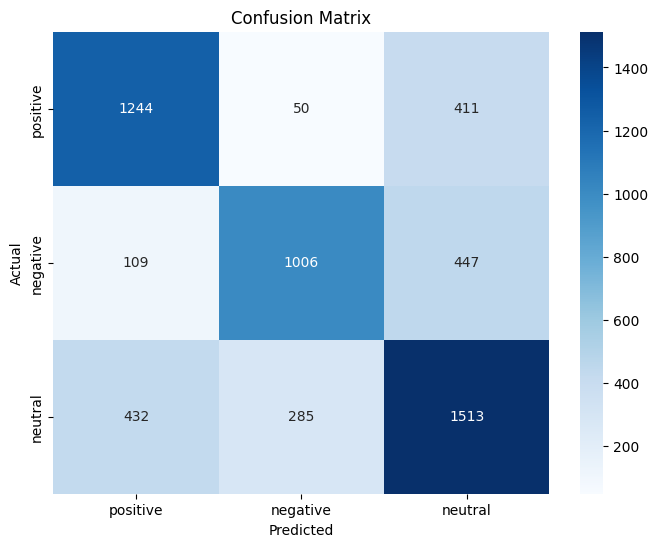

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", conf_matrix)

# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()